<a href="https://colab.research.google.com/github/kate3890/Computer_Vision-Driver_Classification/blob/main/Driver_Behavior_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Individual Assignment

This notebook uses a Convolutional Neural Network (CNN) model using transfer learning with several libraries (Kera & PyTorch) and diffeent architectures in those libraries (VGG16, Res-Net18, Res-Net50).
CNN model (trained with both Keras and PyTorc libraries) to classify images into one of the ten categories:
*   c0: safe driving
*   c1: texting - right
*   c2: talking on the phone - right
*   c3: texting - left
*   c4: talking on the phone - left
*   c5: operating the radio
*   c6: drinking
*   c7: reaching behind
*   c8: hair and makeup
*   c9: talking to passenger

Transfer Learning is a technique where an existing trained model (in this case - VGG16, Res-Net18, Res-Net50) is used and its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, the model benefits from the feature extraction training that was performed on the base model to build a classification model for your own specific set of object classes.

The model first trained on Keras is then reimplemented in PyTorch in hopes of providing some useful insights. For the purpose of this assignment, the results are then compared in order to give sufficient advice on future training and testing of the model.

## Using transfer learning to train a CNN (Keras)

**Steps for the first model: **

1. Preprocessing the data and importing the VGG16 model from Keras applications.
2. Create an instance of the VGG16 model, specifying that the weights that were learned when the model was trained on the ImageNet dataset.
3. Then freezing the base model layers so they won't be updated during training.
4. Creating my own model that includes the layers of the base model followed by a new flatten layer (to flatten the 3D output of the base model to 1D), and a Dense layer with 10 nodes for classification (for 10 classes).'Softmax' activation function in the output layer, which is common for multi-class classification problems.
5. Compiling my model with the **Adam optimizer** and the categorical cross entropy loss function, which is suitable for multi-class classification problems.
6. Then training the new model using training data for a certain number of epochs, and visualising the results


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

from tensorflow import keras

from keras import backend as K

print('Keras version:',keras.__version__)


Keras version: 2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


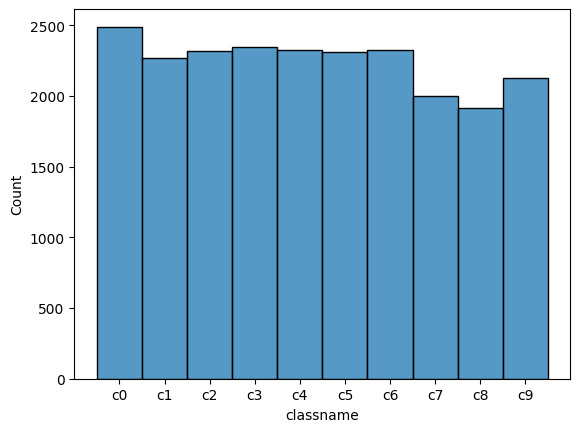

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/ComputerVision_Individual/driver_imgs_list.csv')

# Display the first few rows of the dataframe
print(df.head())

# Plot a histogram showing the distribution of the classes
sns.histplot(df['classname'])
plt.show()

### Data Preprocessing

A function is used to load and preprocess the images to match the input structure of the model.
This involved loading the image, resizing it to the appropriate dimensions (64x64), and converting it into an array.

In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator
!find /content/train -name ".DS_Store" -type f -delete


training_folder_name = '/content/gdrive/My Drive/ComputerVision_Individual/train'


classes = sorted(os.listdir(training_folder_name))
print(classes)

pretrained_size = (64,64)
batch_size = 32

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./64,
                             validation_split=0.2) # hold back 20% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


find: ‘/content/train’: No such file or directory
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Getting Data...
Preparing training dataset...
Found 17963 images belonging to 10 classes.
Preparing validation dataset...
Found 4486 images belonging to 10 classes.


### Pre trained model (VGG16) as a base

 VGG16 model as a base model for transfer learning. This model has been pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

In this example, I am taking the VGG16 model, removing the top (i.e., the last, fully-connected layer), and adding a new Dense layer with 10 nodes, using softmax activation.

All layers of VGG16 are frozen so their weights will not be updated during training.

The model is then compiled with the Adam optimizer and the categorical cross-entropy loss function, which is appropriate for multi-class, single-label classification.

The model can then be fit to data using the model.fit function.

In [ ]:
from keras.applications.vgg16 import VGG16

# Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the layers in the base model so that they are not trained when we fit the model to our data
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with the output of the base model, which we will then add our own layer to
from keras.models import Model
from keras.layers import Flatten, Dense

x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output
predictions = Dense(10, activation='softmax')(x)  # should match number of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (using adam optimiser)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#trying with nadam optimiser as well
#model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])



58889256/58889256 [==============================] - 0s 0us/step


### Freezing already trained layers

This is done so the weights of these pre-trained layers will not change during training. It means the model will keep the learned features from its training on the ImageNet dataset.

In [ ]:
from keras import Model
from keras.layers import Flatten, Dense
from keras import optimizers

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Training the model

With the layers of the CNN defined, we're ready to train the top layer using image data. The model is trained on 1 epoch which is not particularly ideal. But due to the time and CPU constrains I had a hard time using more than 1

In [ ]:
num_epochs = 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs)


561/561 [==============================] - 5229s 9s/step - loss: 0.9779 - accuracy: 0.7374 - val_loss: 0.5435 - val_accuracy: 0.8855


After training the model, we see that for the Keras-based CNN model, I have achieved a training accuracy of 73.74% and a validation accuracy of 88.55%. So now the model can be used

### Using the trained model


In [ ]:
def resize_image(src_img, size=(64,64), bg_color="white"):
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

def predict_image(classifier, image_array):
    import numpy as np
    from keras.preprocessing import image

    # Convert the PIL image to a numpy array
    img_features = image.img_to_array(image_array)

    # Our model was trained on 64x64 images, so resize it
    img_features = np.resize(img_features, (1, 64, 64, 3))
    img_features = img_features.astype('float32')
    img_features /= 255

    # These are the classes our model can predict
    classnames = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

    # Predict the class of each input image
    predictions = classifier.predict(img_features)

    # Get the index of the highest probability
    class_idx = np.argmax(predictions[0])

    # return the class name
    return classnames[int(class_idx)]


print("Functions created - ready to use model for inference.")


Functions created - ready to use model for inference.


### Visualising the results

Since the test folder couldn't be uploaded without being zipped, I am first unzipping it here here.

In [ ]:
import zipfile

test_ref = zipfile.ZipFile('/content/gdrive/MyDrive/ComputerVision_Individual/test.zip', 'r')
test_ref.extractall('/content/test/test')
test_ref.close()

Printing names of some images to test the unzipping

In [ ]:
import os

test_dir = '/content/test/test'
files = os.listdir(test_dir)
image_files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]

# Print the first 10 images
print(image_files[:10])


['img_101245.jpg', 'img_36635.jpg', 'img_76797.jpg', 'img_98371.jpg', 'img_50059.jpg', 'img_59542.jpg', 'img_14015.jpg', 'img_28575.jpg', 'img_71293.jpg', 'img_83298.jpg']


The code will now load each test image, preprocess it in the same way as the training images were preprocessed, and make a prediction. Then it will add the image and its predicted label to their respective lists. At the end, it will plot a few images along with the predicted class name.

Visualization: We displayed the test images along with their predicted labels. This is a helpful way to visually assess how well the model is performing.

1/1 [==============================] - 0s 126ms/step


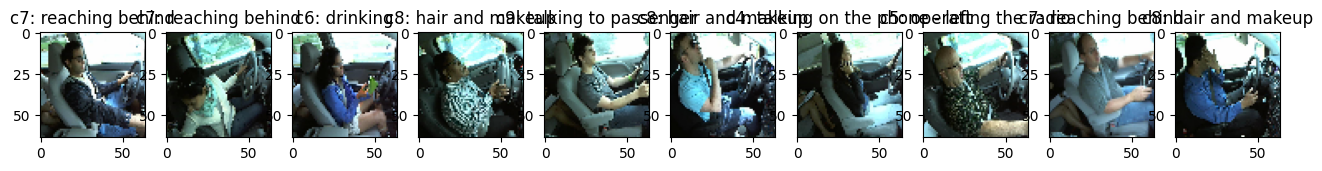

In [ ]:
import os
from random import randint
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline


# Define the class names
classnames = ['c0: safe driving', 'c1: texting - right', 'c2: talking on the phone - right',
              'c3: texting - left', 'c4: talking on the phone - left', 'c5: operating the radio',
              'c6: drinking', 'c7: reaching behind', 'c8: hair and makeup', 'c9: talking to passenger']

# Get the list of test image files
test_folder = '/content/test/test'
test_image_files = os.listdir(test_folder)

# Create an empty list to store the images and their predictions
images = []
predictions = []

# Go through the first 10 image files and make predictions
for file_idx in range(10):  # we only consider first 10 images
    if not test_image_files[file_idx].endswith('.jpg'):
        continue # skip non-image files
    image_path = os.path.join(test_folder, test_image_files[file_idx])

    # Load and preprocess the image
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = expanded_img_array / 255.  # same preprocessing as before

    # Predict the class of the image
    preds = model.predict(preprocessed_img)
    class_idx = np.argmax(preds[0])  # the index of the class with highest probability
    pred_label = classnames[class_idx]  # get the label associated with the predicted class

    # Add the image and its prediction to their respective lists
    images.append(img)
    predictions.append(pred_label)

# Plot each image with its corresponding prediction
fig = plt.figure(figsize=(16, 12))
for idx in range(len(images)):
    a = fig.add_subplot(1, len(images), idx + 1)
    imgplot = plt.imshow(images[idx])
    a.set_title(predictions[idx])




In te above I am using a pre-trained VGG16 model without its top layers, adding my own classification layers, and then training this new model on the dataset.

This approach is called Transfer Learning because I am transferring knowledge from one model trained on a large dataset to a new model to be trained on a smaller dataset.

## Using transfer learning to train a CNN (PyTorch)

Importing libraries so I can run and train this model independently from the above code and not waste time rerunning the above

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.0.1+cu118


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Preprocessing

PyTorch includes functions for loading and transforming data. These are used to create an iterative loader for training data, and a second iterative loader for test data (which we'll use to validate the trained model).

In [ ]:
def load_dataset(data_path):
    # Resize to 64 x 64 (same as what was used in keras) and convert to Tensor
    transformation = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )

    # Split into training (80%) and testing (20%) datasets - Matches the validation I use for CNN Keras
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    # define a loader for the training data, trying with both 15 and 30 size batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        #batch_size=30
        batch_size=15,
        num_workers=0,
        shuffle=False
    )

    # define a loader for the testing data
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        #batch_size=30
        batch_size=15,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader


In [ ]:
import os

# The images are in a folder named 'driver_actions'
training_folder_name = '/content/gdrive/My Drive/ComputerVision_Individual/train'

# The folder contains a subfolder for each class of action
classes = sorted(os.listdir(training_folder_name))
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(training_folder_name)
print("Data loaders ready to read", training_folder_name)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Data loaders ready to read /content/gdrive/My Drive/ComputerVision_Individual/train


### Pre trained model (RES-NET-18) as a base

I will be training my model using a ResNet18 (Residual Neural Network), which is a type of convolutional neural network (CNN) architecture that has been pre-trained on a large dataset. It is a form of transfer learning, where a model developed for one task is used as the starting point for a model on a second task.

Here I loaded a pre-trained ResNet-18 model from PyTorch's model zoo, which has been trained on the ImageNet dataset. This model has learned a lot of features from the large ImageNet dataset which is very beneficial.

Then I am freezing the parameters of the model by setting requires_grad = False. This means that these parameters will not be updated during training.

*This is typically done when you want train only the newly added layers.*


Next, I am replacing the fully connected layer (the last layer) of the pre-trained model with a new fully connected layer that matches the number of classes in the dataset (len(classes)). This is the layer I will train with my dataset.


In [ ]:
model_resnet = torchvision.models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(classes))

# Now print the full model, which will include the layers of the base model plus the linear layer we added
print(model_resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training the model


The train function is defined to train the model. During each epoch, the model makes predictions based on the input data and the current weights. The difference between the predictions and the actual target values is calculated using a loss function (Cross Entropy Loss in this case). The optimizer (Adam) then adjusts the weights to minimize the loss.

The test function is defined to validate the model. The model makes predictions based on the validation data and the current weights. The difference between the predictions and the actual target values is again calculated using the same loss function. However, unlike in the training function, the weights are not adjusted in the validation function. Instead, the function calculates the average loss and the accuracy of the model.

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / batch_idx+1
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss

# Now using the train and test functions to train and test the model

device = "cpu"
if (torch.cuda.is_available()):

    device = "cuda"
print('Training on', device)

# Creating an instance of the model class and allocate it to the device
model_resnet = model_resnet.to(device)

# Using an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Specifying the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Tracking metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Training over 1 epochs - more the one was not possible due to the time and CPU constrains
epochs = 1
for epoch in range(1, epochs + 1):
        train_loss = train(model_resnet, device, train_loader, optimizer, epoch)
        test_loss = test(model_resnet, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)


Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.171059
	Training batch 2 Loss: 0.526947
	Training batch 3 Loss: 1.110448
	Training batch 4 Loss: 0.585158
	Training batch 5 Loss: 1.195159
	Training batch 6 Loss: 1.394084
	Training batch 7 Loss: 1.207322
	Training batch 8 Loss: 1.634849
	Training batch 9 Loss: 1.452845
	Training batch 10 Loss: 1.493090
	Training batch 11 Loss: 1.145400
	Training batch 12 Loss: 1.145826
	Training batch 13 Loss: 1.164503
	Training batch 14 Loss: 0.807377
	Training batch 15 Loss: 1.080770
	Training batch 16 Loss: 0.843475
	Training batch 17 Loss: 1.071296
	Training batch 18 Loss: 1.209679
	Training batch 19 Loss: 1.143103
	Training batch 20 Loss: 1.097717
	Training batch 21 Loss: 1.817836
	Training batch 22 Loss: 1.277333
	Training batch 23 Loss: 1.637364
	Training batch 24 Loss: 1.078749
	Training batch 25 Loss: 1.488764
	Training batch 26 Loss: 1.287921
	Training batch 27 Loss: 1.018602
	Training batch 28 Loss: 0.870282
	Training batch 29 Loss: 1.23573

The results indicate that the model is performing reasonably well. The average loss on the training set is reducing, which is a good sign because it means the model is learning from the data. Furthermore, the model has an accuracy of 77% on the validation set.

However, this is just after one epoch. Typically, deep learning models are trained for numerous epochs until the validation loss stops decreasing (or starts increasing, indicating overfitting). However, due to the purpose of this assignment I just used 1.

### Using the trained model + Visualisation

In [ ]:
def predict_image(classifier, image_array, device):

    # Set the classifier model to evaluation mode
    classifier.eval()

    # These are the classes our model will predict
    class_names = ['c0: safe driving', 'c1: texting - right', 'c2: talking on the phone - right',
              'c3: texting - left', 'c4: talking on the phone - left', 'c5: operating the radio',
              'c6: drinking', 'c7: reaching behind', 'c8: hair and makeup', 'c9: talking to passenger']


    # Applying the same transformations as did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocessing the images
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Moving the input to the device
    input_features = image_tensor.to(device)

    # Predicting the class of each input image
    predictions = classifier(input_features)

    predicted_classes = []
    # Converting the predictions to a numpy array
    for prediction in predictions.data.cpu().numpy():
        class_idx = np.argmax(prediction)
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)


again unzipping the folder here, to avoid rerunning the full notebook

In [ ]:
import zipfile

test_ref = zipfile.ZipFile('/content/gdrive/MyDrive/ComputerVision_Individual/test.zip', 'r')
test_ref.extractall('/content/test/test')
test_ref.close()

In [ ]:
import os

test_dir = '/content/test/test'
files = os.listdir(test_dir)
image_files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]

# Print the first 10 images
print(image_files[:10])

['img_101245.jpg', 'img_36635.jpg', 'img_76797.jpg', 'img_98371.jpg', 'img_50059.jpg', 'img_59542.jpg', 'img_14015.jpg', 'img_28575.jpg', 'img_71293.jpg', 'img_83298.jpg']


In [ ]:
def resize_image(src_img, size=(64,64), bg_color="white"):
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

<Figure size 1200x800 with 0 Axes>

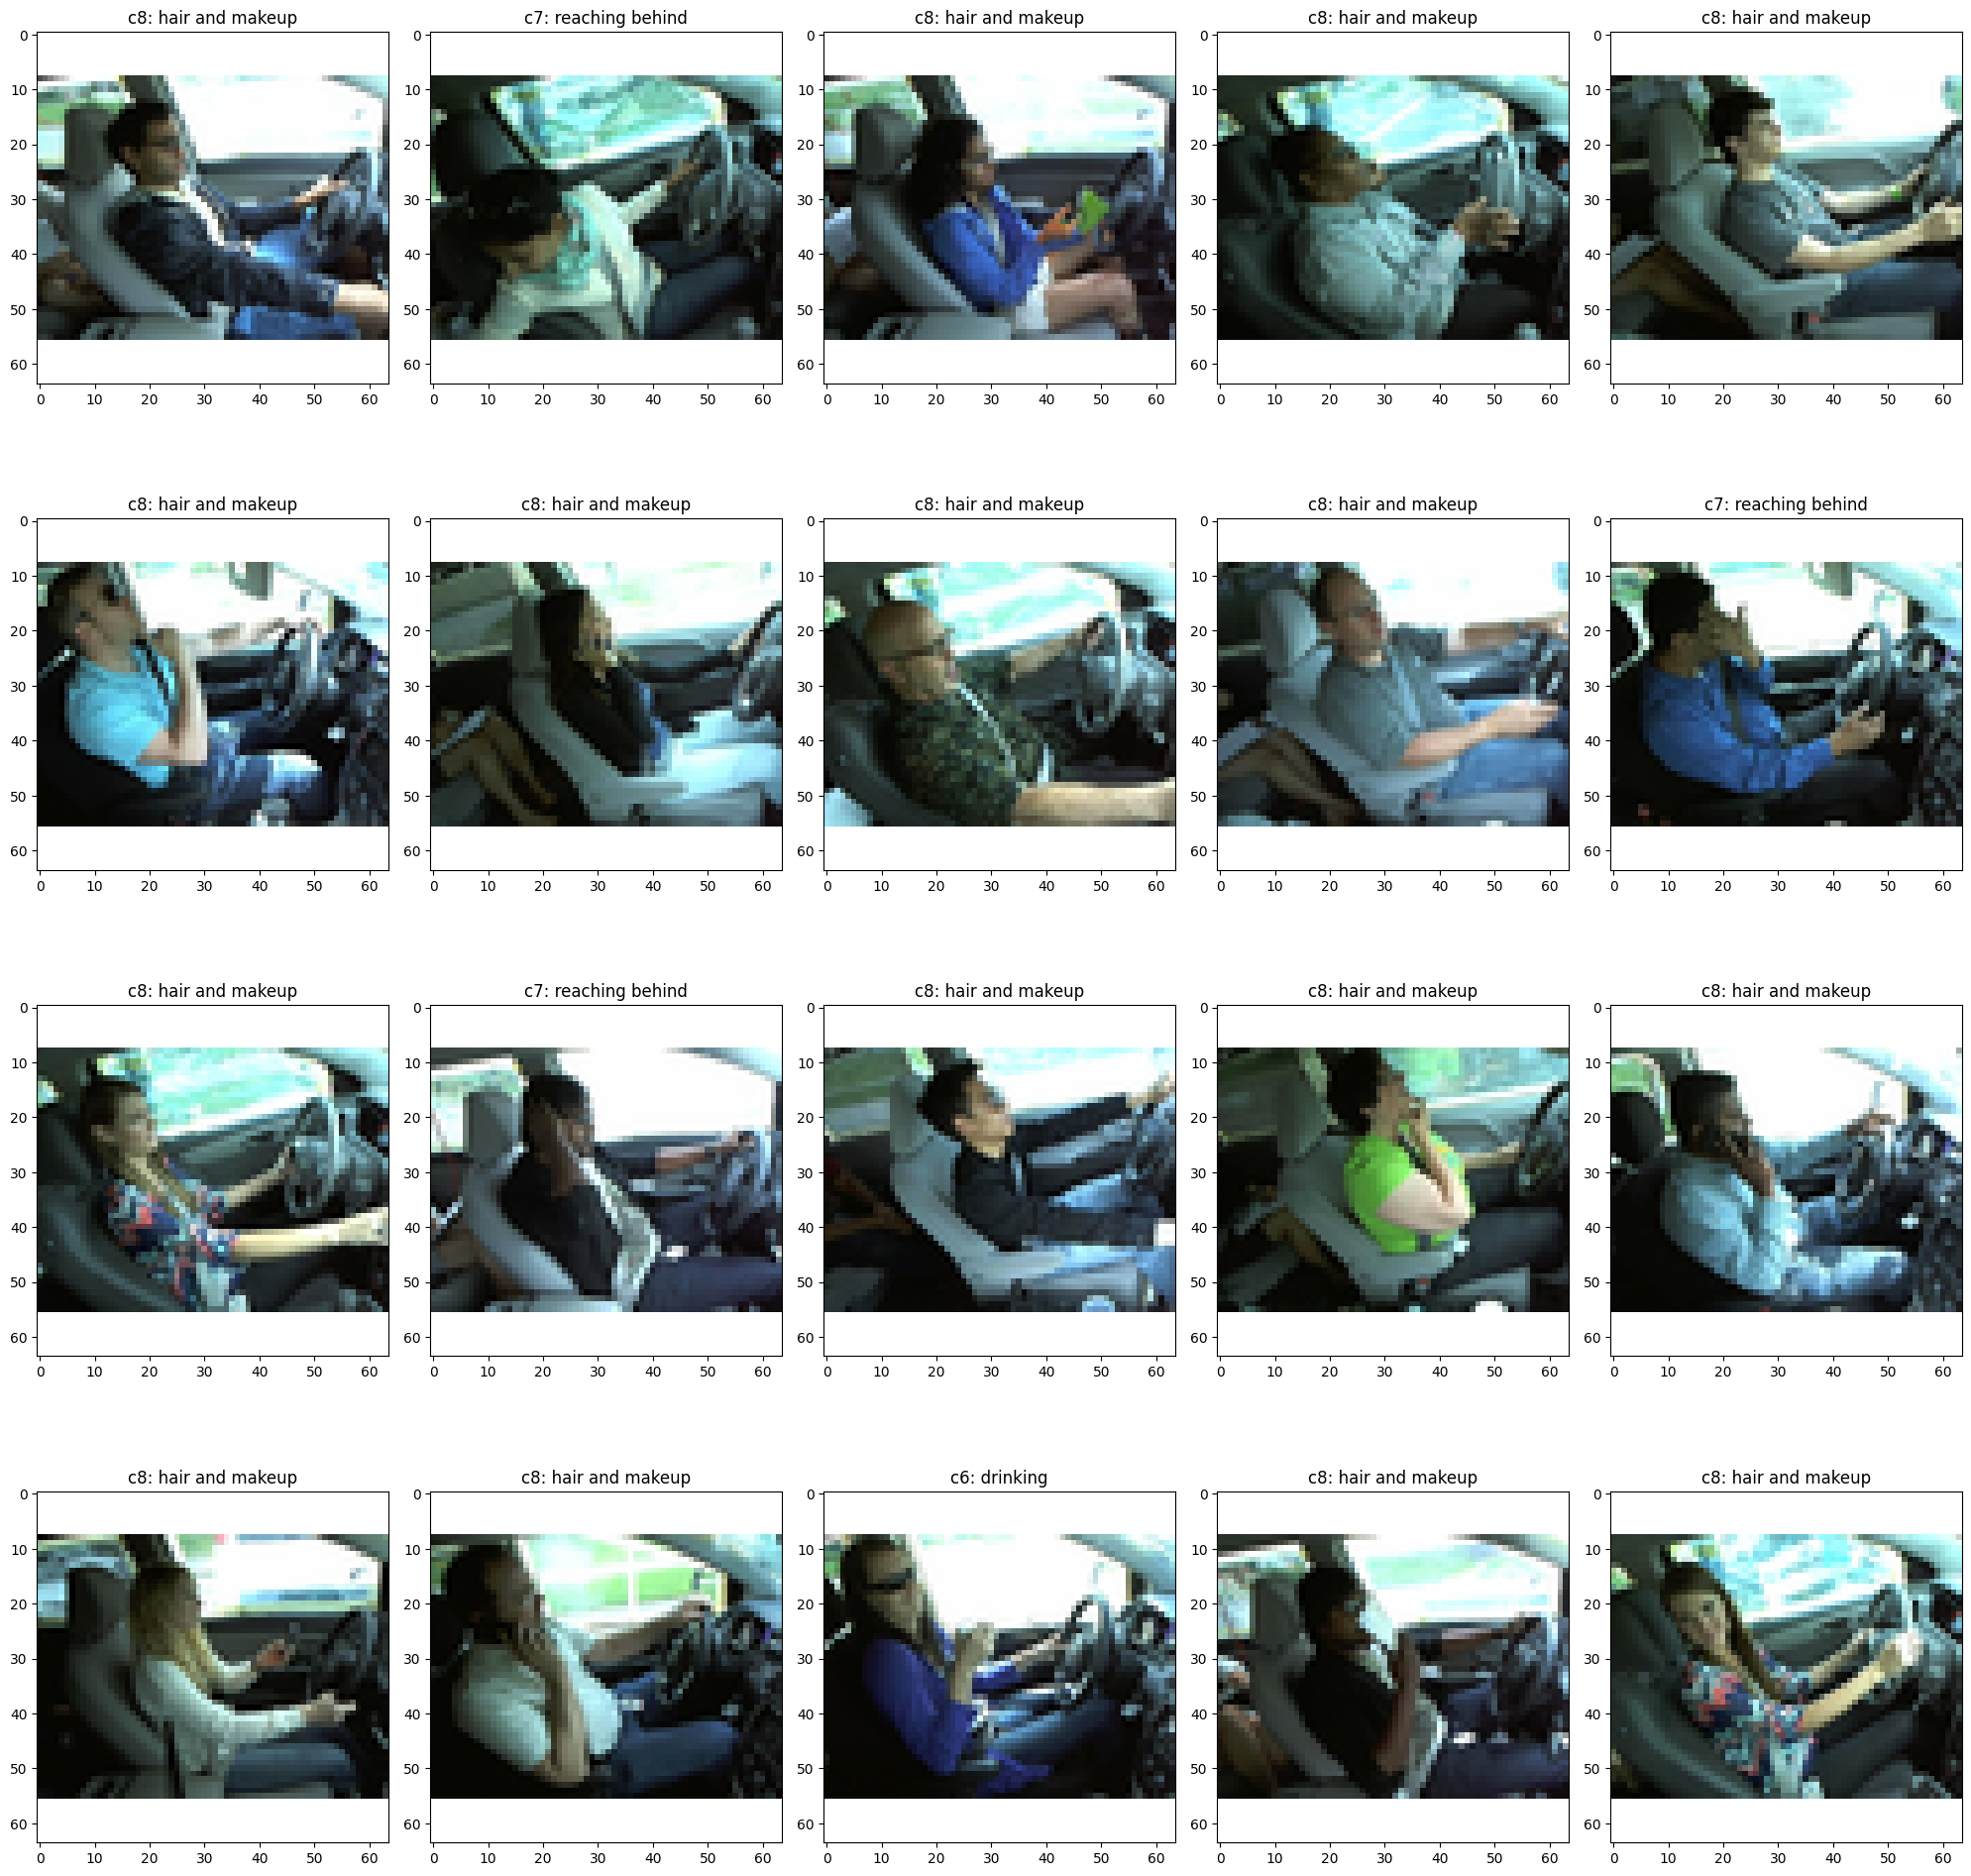

In [ ]:
import os
from random import randint
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

model_resnet.to("cpu")

# Get the list of test image files
test_folder = '/content/test/test'
test_image_files = os.listdir(test_folder)


# Empty array on which to store the images
image_arrays = []

size = (64,64)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the list of test image files
test_image_files = os.listdir(test_folder)

# Set figure size
fig = plt.figure(figsize=(20, 20))

# Go through the first 20 image files and make predictions
for file_idx in range(20):  # we consider the first 20 images
    if not test_image_files[file_idx].endswith('.jpg'):
        continue
    image_path = os.path.join(test_folder, test_image_files[file_idx])

    # Open the image file
    img = Image.open(image_path)

    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))

    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
predictions = predict_image(model_resnet, np.array(image_arrays), device)

# plot each image with its corresponding prediction
for idx in range(len(predictions)):
    # Create a subplot for each image
    a=fig.add_subplot(4,5,idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])


plt.tight_layout()


### Pre trained model (RES-NET-50) as a base

The ResNet (Residual Network) architecture comes in different sizes, such as 18, 34, 50, 101, and 152 layers. These are determined by the number of layers within them and they have been pre-trained on the ImageNet dataset.

ResNet-18 is a smaller model compared to ResNet-50. In general, a larger model (more layers) is capable of learning more complex patterns in the data. But this also means the model is more prone to overfitting especially when there isn't enough data to train it, and it may require more computational resources and time to train.

I started with ResNet-18, which is a smaller and simpler model, to get a baseline performance fast and with fewer resources, then I wanted to try the Res-Net 50 to see how is comapres.


Since the ResNet18 did not work exacly as I was hoping and did not provide accurate enough result even with the accuracy score of more than 70%, I wanted to try another pre-trained model - ResNet50 in PyTorch to see if the results would be any better with it

In [ ]:
import torchvision.models as models

# Load the pre-trained model
model_resnet50 = models.resnet50(pretrained=True)

# Freeze all the layers in the network
for param in model_resnet50.parameters():
    param.requires_grad = False

# Replace the last layer (fc layer) to match our number of classes
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features, len(classes))

# Print the model architecture
print(model_resnet50)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Using the Res-Net-50 model


In the code below, I am training the ResNet-50 model with an Adam optimizer with a learning rate of 0.01. The Adam optimizer is a popular choice because it combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. It adapts the learning rate for each weight in the model individually and computes adaptive learning rates for different parameters. However then I am also trying the same model with teh SGD optimiser to see how it compares.

Furthermore, I am also using a learning rate scheduler which is StepLR, it reduces the learning rate by a factor of gamma every step_size epochs. This is useful in situations where you want the model to 'settle down' into a minimum, rather than continuously jumping around due to a high learning rate. Lowering the learning rate every so often can help the model to converge. In this case the trainign is done for one epoch for faster experimentation and then repeated for 2 two compare the results






In [ ]:
from torch.optim.lr_scheduler import StepLR

def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    scheduler.step()
    avg_loss = train_loss / (batch_idx + 1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Training on', device)

model_resnet = model_resnet.to(device)

# Use an "Adam" optimizer to adjust weights then trying with SGD
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9)


# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Define the learning rate scheduler, learning rate scheduler which decreases the learning rate
#after every 30 steps by a factor of 0.1 (StepLR with step_size=30 and gamma=0.1).
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 1 epochs and then over 2 to see the results

#epochs = 2
epochs = 1
for epoch in range(1, epochs + 1):
    train_loss = train(model_resnet, device, train_loader, optimizer, scheduler, epoch)
    test_loss = test(model_resnet, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)



Training on cpu
Epoch: 1
Training set: Average loss: 2.053073
Validation set: Average loss: 1.6664, Accuracy: 3341/4490 (74%)



*When training on 2 epochs (Adam optimiser) the following results were obtained:*

Training on cpu
Epoch: 1
Training set: Average loss: 2.033152
Validation set: Average loss: 1.4262, Accuracy: 3265/4490 (73%)
Epoch: 2
Training set: Average loss: 1.985661
Validation set: Average loss: 1.5064, Accuracy: 3303/4490 (74%)

*When training on 2 epochs (SGD optimiser) the following results were obtained*:

Training on cpu
Epoch: 1
Training set: Average loss: 2.020747
Validation set: Average loss: 1.6372, Accuracy: 3268/4490 (73%)
Epoch: 2
Training set: Average loss: 1.994617
Validation set: Average loss: 1.6482, Accuracy: 3306/4490 (74%)

### Visulisation of results

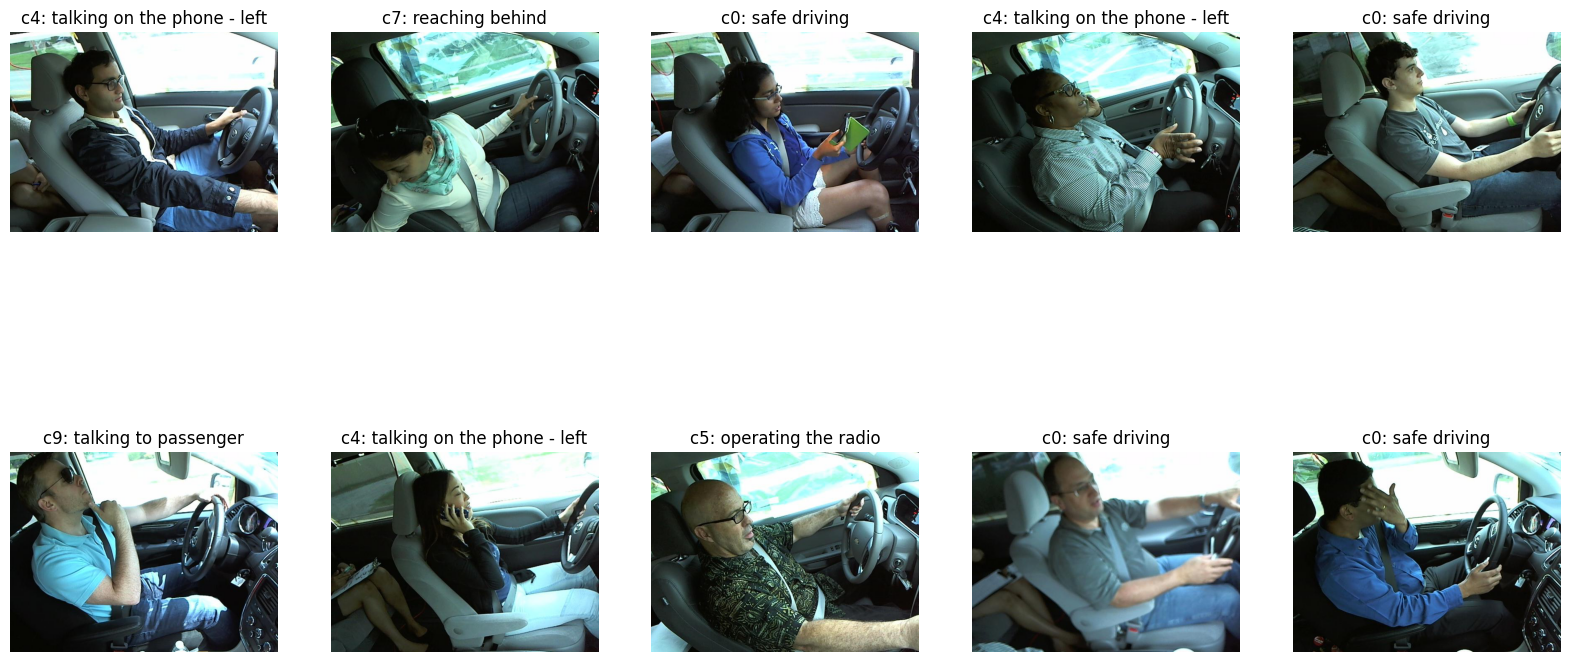

In [ ]:

import os
from PIL import Image
import matplotlib.pyplot as plt



image_directory = '/content/test/test'

image_filenames = os.listdir(image_directory)

image_list = [Image.open(os.path.join(image_directory, filename)) for filename in image_filenames[:10]]  # loading first 10 images for demo

# Apply the model to the list of images
predicted_labels = predict_image(model_resnet, image_list, device)


def visualize_predictions(images, labels):
    figure = plt.figure(figsize=(20, 10))
    cols, rows = 5, 2
    for i in range(1, cols * rows + 1):
        img = images[i-1]
        figure.add_subplot(rows, cols, i)
        plt.title(labels[i-1])
        plt.axis("off")
        plt.imshow(img, cmap='gray')
    plt.show()

# Now visualize the images with predicted labels
visualize_predictions(image_list, predicted_labels)


def predict_image(classifier, image_array, device):

    # Set the classifier model to evaluation mode
    classifier.eval()

    # These are the classes the model can predict
    class_names = ['c0: safe driving', 'c1: texting - right', 'c2: talking on the phone - right',
              'c3: texting - left', 'c4: talking on the phone - left', 'c5: operating the radio',
              'c6: drinking', 'c7: reaching behind', 'c8: hair and makeup', 'c9: talking to passenger']


    transformation = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


    # Preprocess the images
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Move the input to the device
    input_features = image_tensor.to(device)

    # Predict the class of each input image
    predictions = classifier(input_features)

    predicted_classes = []
    # Convert the predictions to a numpy array
    for prediction in predictions.data.cpu().numpy():
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)


## Observations

Both models have acieved relatively good accurecy scores.

For the Keras-based CNN model, I achieved a training accuracy of 73.74% and a validation accuracy of 88.55%.

For the PyTorch-based ResNet model (Transfer Learning), I achieved a validation accuracy of 77% after just one epoch.

As part of the further experiment, I trained a ResNet-50 model using two different optimizers and for two epochs each, with the following observations:

When using the Adam optimizer:

*  After the first epoch, the average training loss was 2.033152 and the validation accuracy was 73%.
*  After the second epoch, the average training loss dropped slightly to 1.985661 and the validation accuracy slightly improved to 74%.

When using the SGD optimizer:

*  After the first epoch, the average training loss was 2.020747 and the validation accuracy was 73%.
*  After the second epoch, the average training loss slightly reduced to 1.994617 and the validation accuracy slightly improved to 74%.


When comparing these results with the initial ResNet-18 and Keras CNN model, it is noticable that:

ResNet-50 models (both with Adam and SGD optimizers) performed slightly worse than the initial ResNet-18 model with validation accuracies around 73-74% as compared to 77%. However, these models were trained only for two epochs, and it's quite possible that with more epochs, these models could potentially improve their performance, which would be a good place to start experimenting.

Compared to the Keras model, the PyTorch models (both ResNet-18 and ResNet-50) have lower validation accuracy (88.55% vs 77%). However, this might be due to the different model architectures and the number of epochs for which the models were trained. The Keras model was trained from scratch, while the PyTorch models utilized transfer learning from pre-trained ResNet models. Finally, in terms of optimizers, both Adam and SGD resulted in similar performance in the context of the ResNet-50 model.


## Conclusion

For the purpose of this assignment I have built a neural network from scratch. I have created a Convolutional Neural Network (CNN) model using Keras, where I designed the architecture of the model and trained it from scratch using the provided data. Then I built a neural network using transfer learning: Where I used PyTorch to load a pre-trained ResNet models and fine-tuned them on the dataset.

*Considering PyTorch has pretrained models it took significantly less time for training and allowed for some experimentation *

For further improvements it would be also interesting to experiment with several hyperparameters, which was a complicated task in this case due to the CPU and time constrains

Hyperparameters are the variables which determine the network structure (e.g. number of hidden units) and the variables which determine how the network is trained (e.g. learning rate).


In both Models it would be interesing to experiment with:


*  **Learning rate:** This is one of the most important hyperparameters. Experimenting with different learning rates can affects the training of the models.

*  **Batch size:** This is the number of samples that will be passed through the network at once. My current batch size for both models is 15. However, it can be reduced/increased

*  **Number of epochs:** This is the number of times the entire dataset will be passed forward and backward through the neural network. I was only able to use 1 epich on both models due to the significant time it take with even one epoche

*  **Optimizer:** I have used Adam optimizer for the models, it would be interesting to try other optimizers like SGD, RMSprop and see how it affects the end results.

*  **Number of layers and neurons in each layer**: This is applicable for the first model (Keras). Adding more layers to the network or changing the number of neurons in the layers can have significant effects on the model


